# Procesamiento de Lenguaje Natural


**Vanessa Gómez Verdejo, Emilio Parrado Hernández,  Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />


In [19]:
%matplotlib inline  
# Figures plotted inside the notebook
%config InlineBackend.figure_format = 'svg'  
# High quality figures
import matplotlib.pyplot as plt
import numpy as np

# Representación de documentos mediante vectores

En este notebook vamos a aprender a usar la librería [gensim](https://radimrehurek.com/gensim/) para construir un diccionario en base a nuestro corpus de documentos y representar cada uno de ellos mediante un vector real, representación que ya es susceptible de combinarse con algoritmos de aprendizaje automático tales como agrupación y clasificación.

Para empezar a trabajar vamos a usar el corpus **inaugural**, uno de los corpus de datos incluidos en NLTK y que consiste en 58 documentos de texto con los discursos presidenciales de los presidentes de EEUU.

La siguiente celda de código nos muestra cómo cargar el corpus...

In [5]:
import nltk
from nltk.corpus import inaugural
nltk.download('inaugural')



[nltk_data] Downloading package inaugural to /Users/olmos/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

> **Ejercicio 1**: Cargue la función de normalizado de texto implementada en la sesión anterior y construya `corpus_prec`, una lista con cada uno de los documentos del corpus `inaugural` preprocesados.

In [6]:
import spacy

# Cargamos el modelo
nlp = spacy.load("en_core_web_sm")

def normalize_Spacy(text):
    text2 = nlp(text)
    normalized_text = [w.lemma_.lower() for w in text2 if not w.is_stop 
                  and not w.is_punct and (w.is_alpha or w.is_digit)]
    return normalized_text

In [8]:
corpus_prec = [normalize_Spacy(inaugural.raw(file)) for file in inaugural.fileids()]

In [9]:
print(corpus_prec[0][:20])

['fellow', 'citizens', 'senate', 'house', 'representatives', 'vicissitude', 'incident', 'life', 'event', 'fill', 'great', 'anxiety', 'notification', 'transmit', 'order', 'receive', 'day', 'present', 'month', 'hand']


El siguiente código muestra los 20 primeros tokens del corpus preprocesado:

In [10]:
print('Número de documentos en el corpus preprocesado:')
print(len(corpus_prec))
print('**********')
print('Algunos de los elementos del primer documento preprocesado')
print(corpus_prec[0][:20])
print('**********')
print('Algunos de los elementos del segundo documento preprocesado')
print(corpus_prec[1][:20])
print('**********')
print('Algunos de los elementos del tercer documento preprocesado')
print(corpus_prec[3][:20])

Número de documentos en el corpus preprocesado:
59
**********
Algunos de los elementos del primer documento preprocesado
['fellow', 'citizens', 'senate', 'house', 'representatives', 'vicissitude', 'incident', 'life', 'event', 'fill', 'great', 'anxiety', 'notification', 'transmit', 'order', 'receive', 'day', 'present', 'month', 'hand']
**********
Algunos de los elementos del segundo documento preprocesado
['fellow', 'citizen', 'call', 'voice', 'country', 'execute', 'function', 'chief', 'magistrate', 'occasion', 'proper', 'shall', 'arrive', 'shall', 'endeavor', 'express', 'high', 'sense', 'entertain', 'distinguished']
**********
Algunos de los elementos del tercer documento preprocesado
['friends', 'fellow', 'citizens', 'call', 'undertake', 'duty', 'executive', 'office', 'country', 'avail', 'presence', 'portion', 'fellow', 'citizen', 'assemble', 'express', 'grateful', 'thank', 'favor', 'pleased']


## 1.2 Bag of Words (BOW)

Si este análisis de frecuencia lo hicieramos a nivel de documento, en vez de a nivel de corpus, nos estaría indicando la ocurrencia de cada palabra por documento. De hecho, este conteo de palabras por documento es lo que se conoce como **bag-of-words** (bolsa de palabras) o, de manera abreviada como , **BoW**. En concreto, **bag-of-words** es una representación de texto que describe la ocurrencia de palabras dentro de un documento. 

Se llama "bolsa" de palabras, porque cualquier información sobre el orden o la estructura de las palabras en el documento es descartada. El modelo sólo se ocupa de si las palabras conocidas aparecen en el documento, no de dónde aparecen en el documento.

Para obtener la representación BoW podemos utilizar varias librerías. `Sklearn` incluye funcionalidades para el análisis de texto, y las propias funcionalidades de NLTK para el conteo de palabras o análisis frecuencial de palabras podrían valernos. Sin embargo, en esta sección vamos a ver cómo usar la librería de [`gensim`](https://pypi.org/project/gensim/) diseñada específicamente para el procesado de texto, permitiendo un procesado muy eficiente para grandes corpus e incluyendo funcionalides adicionales de gran utilidad. 


El proceso de generación del BoW tiene dos pasos:
1. Generación del vocabulario del corpus. Este vocabulario se genera mediante un **diccionario** que almacena de manera ordenada un vocabulario de palabras conocidas (a nivel de corpus).
2. **Vectorización de documentos** o generación del BoW. Se calcula una medida de la presencia de palabras conocidas (las que están en el vocabulario); para ello, realiza  un conteo del número de veces que cada palabra del diccionario aparece dentro de cada documento.

Veamos a continuación, como implementar estos pasos: 


### Generación del diccionario

In [11]:
import gensim

# Create dictionary of tokens: the input is the preprocessed corpus 
D = gensim.corpora.Dictionary(corpus_prec)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 6569 terms
First terms in the dictionary:
0 : accomplish
1 : accordingly
2 : acknowledge
3 : acquit
4 : act
5 : actual
6 : actuate
7 : add
8 : addition
9 : address


Como vemos el diccionario no es más que una lista de palabras. Pero el orden de esta lista será muy importante para la vectorización de cada documento, ya que generaremos tuplas de (`id`, `conteo`) y los `id` serán las posiciones de estas palabras en el diccionario.

Si queremos conocer el `id` asociado a un token en particular, utilizaremos el diccionario `D.token2id`:

In [12]:
print('El id correspondiente al token "actual" es {0}'.format(D.token2id["actual"]))

El id correspondiente al token "actual" es 5


Podemos usar el método `.get` de un diccionario de Python para obtener el id correspondiente a una palabra o `None` si esta no pertenece al diccionario:

In [13]:
print(D.token2id.get("actual"))

print(D.token2id.get("dsañljfasd"))

5
None


### Gestión del Vocabulario

A medida que el tamaño del vocabulario aumenta, también lo hace la representación vectorial de los documentos. En el ejemplo anterior, la longitud del vector de los documentos es igual al número de palabras conocidas.

Para un corpus muy grande, como miles de documentos, la longitud del vector que representará cada documento puede ser de miles o millones de posiciones. 

Además, cada documento puede contener muy pocas de las palabras conocidas en el vocabulario, lo que dificulta el procesado. 

Para evitar esto, es recomendable analizar el diccionario y eliminar tokens que no resulten relevantes: marcas de puntuación que todavía queden o términos que aparecen en muy pocos casos (por lo que no son términos poco informativos) o, incluso, tokens que figuran en todos los documentos del corpus (y no son discriminativos). 




El diccionario de Gensim nos permite filtrar estos terminos fácilmente:

* `.filter_tokens()` nos permite indicar con el parámetro `bad_ids` la lista de ids de las palabras a eliminar o con `good_ids` la lista de los ids de las palabras a dejar en el diccionario (eliminando el resto).

* `.filter_extremes()` permite eliminar palabras/tokens poco o muy frecuentes indicando con los parámetros:
  * `no_below`: se queda con el número de tokens que están contenidas en al menos `no_below` documentos.
  * `no_above`:  se queda con el porcentaje  (fracción del tamaño total del corpus, no un número absoluto) de tokens que no están en más de `no_above` documentos.
  * `keep_n`: directamente se queda con los `keep_n` tokens más frecuentes.
  * `keep_tokens`: listado de tokens que deben permanecer en el diccionario después de ser filtradas.

Veamos como utilizar estas dos funcionalidades...

In [14]:
D.filter_tokens(bad_ids=[0,1,8])  # quitamos del diccionario el término "14th"
n_tokens = len(D)
print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 6566 terms
First terms in the dictionary:
0 : acknowledge
1 : acquit
2 : act
3 : actual
4 : actuate
5 : add
6 : address
7 : administration
8 : adopt
9 : adore


In [15]:
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .75 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=1500)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 1500 terms
First terms in the dictionary:
0 : acknowledge
1 : act
2 : actual
3 : add
4 : address
5 : administration
6 : adopt
7 : advance
8 : advancement
9 : advantage


Esto elimina todas los tokens en el diccionario que son:
1. Los `no_below=5` tokens menos frecuentes  
2. El `no_above=0.75` ($75\%$) de tokens más frecuentes.
3. Después de (1) y (2), guarda sólo los primeros `keep_n` tokens más frecuentes (o guarda todos si `keep_n=None`).



### Refinando el diccionario de nuestro corpus

A continuación, vamos a volver a generar el diccionario de nuestro corpus y analizar la aparición de palabras por documento. A partir de este análisis decida qué palabras eliminaría del diccionario y use las funciones anteriores para refinar el diccionario.

Para este análisis usamos algunos de los métodos de la clase diccionario de gensim como `dfs` (calcula en cuántos documentos del corpus aparece cada palabra del vocabulario). Puede ver la ayuda en este [link](https://radimrehurek.com/gensim/corpora/dictionary.html).

In [16]:
# Recompute the dictionary
D = gensim.corpora.Dictionary(corpus_prec)
n_tokens = len(D)
print(n_tokens)

6569


> **Ejercicio 2**: Cree una lista con el número de documentos en los que aparecen los tokens `president`, `america`, `war`

In [17]:
l = ['president','america','war']

doc_l = [D.dfs[D.token2id[token]] for token in l]

print(doc_l)

[37, 32, 47]


> **Ejercicio 3**: Usando la función `plt.hist()` dibuje el histograma del número de documentos en los que aparece cada palabra del diccionario `D`

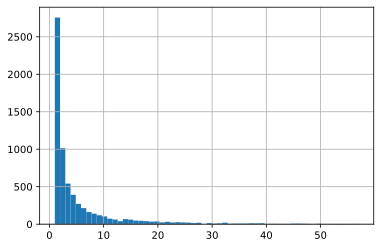

In [20]:
plt.hist(D.dfs.values(),58)
plt.grid()
plt.show()

Observe que hay una cantidad enorme de palabras que solo aparecen en unos pocos documentos.  Por otra parte, hay un cierto número de palabras que aparecen en casi todos los documentos.

> **Ejercicio 4:** Excluya del diccionario todas las palabras que no estén en al menos 6 documentos y aquellas que estén en el 80% de los documentos.

In [21]:
# Incluya aqui su código para limpiar el diccionario
#<SOL>
no_below = 6 #Minimum number of documents to keep a term in the dictionary
no_above = .8 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)
#<SOL>

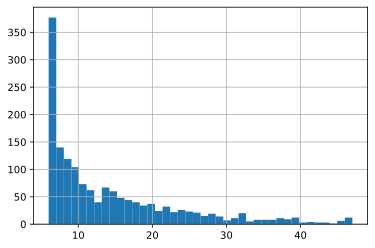

In [22]:
# Analize the word frequency per document again to check your solution
plt.hist(D.dfs.values(),40)
plt.grid()
plt.show()

### Vectorización de los documentos

Una vez definido nuestro diccionario, el último paso es generar el BoW. Para ello, para cada documento, tenemos que generar un vector de longitud el vocabulario y en cada posición un valor con el conteo o número de veces que esa palabra aparece en el documento. De este modo, cada documento se transforma en una lista de tuplas `(id, n)`, donde `id` es el id de la palabra dentro del diccionario y `n` el conteo de esa palabra dentro del documento. 

Para generar esta lista de tuplas vamos a usar el método `.doc2bow()`. En general, `D.doc2bow(token_list)` transforma cualquier lista de tokens en una lista de tuplas `(token_id, n)`, una por cada token en `token_list`, donde `token_id` es el identificador del token (según el diccionario `D`) y `n` es el número de ocurrencias de dicho token en `token_list`. 

Veamos cómo calcular el BoW para el primer documento del corpus y analicemos la salida

In [23]:
corpus_bow = D.doc2bow(corpus_prec[0])

print('Original document (after cleaning, first 20 tokens):')
print(corpus_prec[0][:20])
print('*********************')
print('Sparse vector representation (first 10 components):')
print(corpus_bow[:10])
print('*********************')
print('Word counts for the document (first 10 components):')
list_word_counts = [(D[doc_bow[0]], doc_bow[1]) for doc_bow in corpus_bow[:10]]
print(list_word_counts)

Original document (after cleaning, first 20 tokens):
['fellow', 'citizens', 'senate', 'house', 'representatives', 'vicissitude', 'incident', 'life', 'event', 'fill', 'great', 'anxiety', 'notification', 'transmit', 'order', 'receive', 'day', 'present', 'month', 'hand']
*********************
Sparse vector representation (first 10 components):
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1)]
*********************
Word counts for the document (first 10 components):
[('accomplish', 1), ('acknowledge', 1), ('act', 1), ('actual', 1), ('add', 1), ('address', 1), ('administration', 2), ('adopt', 1), ('advance', 1), ('advancement', 1)]


> **Ejercicio 5**: Obtenga el BoW de todos los documentos del corpus

Almacene la salida en una lista llamada `corpus_bow` donde cada elemento de la lista sea el BoW de un documento, para a continuación poder analizar la salida y representarla.

In [24]:
#<SOL>
corpus_bow = [D.doc2bow(doc) for doc in corpus_prec]
#</SOL>

In [25]:
n_doc=50
print('Original document (after cleaning, first 20 tokens):')
print(corpus_prec[n_doc][:20])
print('*********************')
print('Sparse vector representation (first 10 components):')
print(corpus_bow[n_doc][:10])
print('*********************')
print('Word counts for the document (first 10 components):')
list_word_counts = [(D[doc_bow[0]], doc_bow[1]) for doc_bow in corpus_bow[n_doc][:10]]
print(list_word_counts)


Original document (after cleaning, first 20 tokens):
['chief', 'justice', 'president', 'vice', 'president', 'quayle', 'senator', 'mitchell', 'speaker', 'wright', 'senator', 'dole', 'congressman', 'michael', 'fellow', 'citizen', 'neighbor', 'friend', 'man', 'earn']
*********************
Sparse vector representation (first 10 components):
[(2, 3), (8, 1), (14, 1), (17, 2), (30, 1), (33, 1), (37, 3), (38, 2), (39, 2), (43, 2)]
*********************
Word counts for the document (first 10 components):
[('act', 3), ('advance', 1), ('agency', 1), ('american', 2), ('await', 1), ('bind', 1), ('bring', 3), ('call', 2), ('care', 2), ('choose', 2)]


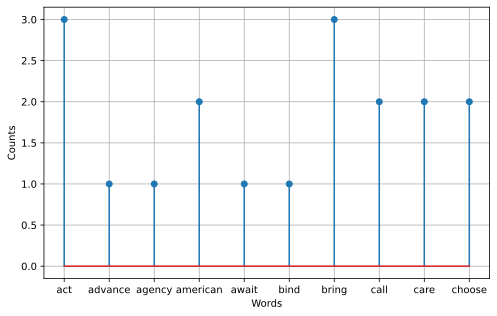

In [26]:
words = [e[0] for e in list_word_counts]
counts = [e[1] for e in list_word_counts]

plt.figure(figsize=(8,5))
plt.stem(words,counts, use_line_collection = True)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.grid()
plt.show()

## 3.3 Representación TF-IDF 

Un problema del BoW es que la frecuencia de las palabras muy frecuentes empiezan a dominar en el documento respecto al resto; por ejemplo, verbos muy comunes o términos habituales en el contexto del corpus pero no tienen tanto "contenido informativo" para el modelo como pueden ser palabras más raras pero tal vez específicas del dominio. Al realizar la gestión del vocabulario hemos visto que podemos eliminar estas palabras tan frecuentes, pero este proceso es bastante manual y es preferible tener una vectorización robusta a esto.

Para ello, la representación TF-IDF (Term Frequency–Inverse Document Frequency) propone reajustar la frecuencia de las palabras en función de la frecuencia con que aparecen en todos los documentos, de modo que se penalicen las puntuaciones de palabras frecuentes si también son frecuentes en todos los documentos. Para ello, el TF-IDF implica el cálculo de dos valores:


**Frecuencia de término (TF)**

Por frecuencia de término $\text{TF}(w)$ nos referimos al número de veces que una palabra $w$ dada ocurre en un documento, dividido por el número total de palabras en dicho documento.
$$ \text{TF}(w,d) =\frac{\text{# veces que $w$ aparece en el documento $d$}}{\text{# total de palabras en el documento $d$}}$$

**Frecuencia de Documento Inversa (IDF)**

Es una medida de cuánta información proporciona la palabra $w$, es decir, si es común o rara en todos los documentos del corpus $D$. Se calcula de la siguiente manera:
$$ \text{IDF}(w,D) =\log \frac{\text{# documentos en el corpus}}{1+\text{# documentos donde la palabra $w$ aparece}}$$
 
A partir de estos valores el **TF-IDF** se calcula de la siguiente manera:

$$\text{TF-IDF}(w,d,D) = \text{TF}(w,d) * \text{IDF}(w,D)$$

Un peso alto en TF-IDF se consigue cuando la palabra tiene una frecuencia alta en el documento y, a la vez, una frecuencia baja en el corpus; por lo tanto, los pesos tienden a filtrar los términos que son comunes a muchos documentos. 

Obsérvese que, a diferencia de la codificación BoW, para el TF-IDF tenemos que parender la codificación conjuntamente con todo el corpus. No obstante, una vez que hemos calculado el BoW para todos los documentos, aprender el modelo TF-IDF es sencillo usando la función [TfidfModel](https://radimrehurek.com/gensim/models/tfidfmodel.html) de Gensim.

In [27]:
from gensim.models import TfidfModel

# fit TFIDF model for all the corpus
model = TfidfModel(corpus_bow)  

# apply model to the first corpus document
vector = model[corpus_bow[0]]  # apply model to the first corpus document
print(vector[:20])



[(0, 0.03726532121384978), (1, 0.049551827804021856), (2, 0.01607380625798083), (3, 0.068829108653932), (4, 0.030984826754827326), (5, 0.054861910207518204), (6, 0.042149883497100485), (7, 0.040894711761104416), (8, 0.02446594137975731), (9, 0.06114240466654067), (10, 0.035584629357608054), (11, 0.028227567597606987), (12, 0.04495202520124112), (13, 0.0578592215549244), (14, 0.06114240466654067), (15, 0.02446594137975731), (16, 0.029578617226458444), (17, 0.01714761846224573), (18, 0.07873899366020909), (19, 0.049551827804021856)]


> **Ejercicio 6**: Obtenga el TFIDF de todos los documentos del corpus

Almacene la salida en una lista llamada `corpus_tfifd` donde cada elemento de la lista sea el TFIDF de un documento, para a continuación poder analizar la salida y representarla.

In [28]:
#<SOL>
# apply model to all corpus document
corpus_tfidf = model[corpus_bow]  # apply model to the first corpus document
#</SOL>

Analicemos esta transformación en comparación con el BoW

In [29]:
n_doc=50
print('Original document (after cleaning), first 20 tokens):')
print(corpus_prec[n_doc][:20])
print('*********************')
print('Sparse TFIDF vector representation (first 10 components):')
print(corpus_tfidf[n_doc][:10])
print('*********************')
print('Word counts for the document (first 10 components):')
list_word_counts = [(D[doc_bow[0]], doc_bow[1]) for doc_bow in corpus_bow[n_doc][:10]]
print(list_word_counts)
print('*********************')
print('TF-IDF for the document (first 10 components):')
list_tfidf = [(D[doc_tfidf[0]], doc_tfidf[1]) for doc_tfidf in corpus_tfidf[n_doc][:10]]
print(list_tfidf)

Original document (after cleaning), first 20 tokens):
['chief', 'justice', 'president', 'vice', 'president', 'quayle', 'senator', 'mitchell', 'speaker', 'wright', 'senator', 'dole', 'congressman', 'michael', 'fellow', 'citizen', 'neighbor', 'friend', 'man', 'earn']
*********************
Sparse TFIDF vector representation (first 10 components):
[(2, 0.03369321403532447), (8, 0.017094814305408056), (14, 0.042721350375891226), (17, 0.011981364168337814), (30, 0.03833305054075943), (33, 0.017939427721672282), (37, 0.026280861674052927), (38, 0.022462142690216312), (39, 0.03762952200988272), (43, 0.039446266864163596)]
*********************
Word counts for the document (first 10 components):
[('act', 3), ('advance', 1), ('agency', 1), ('american', 2), ('await', 1), ('bind', 1), ('bring', 3), ('call', 2), ('care', 2), ('choose', 2)]
*********************
TF-IDF for the document (first 10 components):
[('act', 0.03369321403532447), ('advance', 0.017094814305408056), ('agency', 0.0427213503758

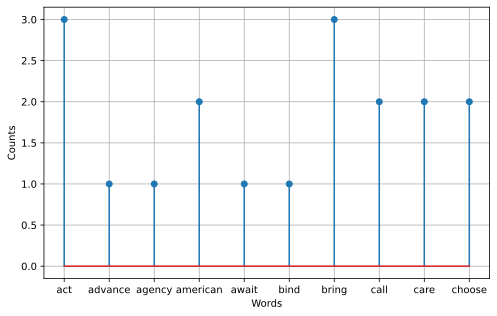

In [30]:
# Plot again the BOW

words = [e[0] for e in list_word_counts]
counts = [e[1] for e in list_word_counts]

plt.figure(figsize=(8,5))
plt.stem(words,counts, use_line_collection = True)
plt.grid()
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

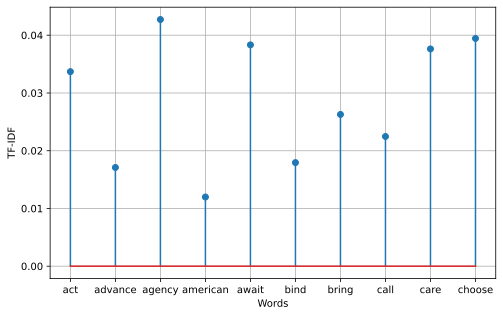

In [31]:
#Plot TF-IDF
words = [e[0] for e in list_tfidf]
tfidf = [e[1] for e in list_tfidf]

plt.figure(figsize=(8,5))
plt.stem(words,tfidf, use_line_collection = True)
plt.grid()
plt.xlabel('Words')
plt.ylabel('TF-IDF')
plt.show()

Compare ambas representaciones... ¿Qué palabras tenían más/menos peso en la representación BoW? ¿Y en la representación TF-IDF? 

## Limitaciones de BoW y TF-IDF

Las representaciones vectoriales que acabamos de ver son sencillas de comprender y aplicar y ofrecen mucha flexibilidad para manejo de información textual. De hecho, se han utilizado con gran éxito en problemas de predicción y clasificación de documentos.

Sin embargo, sufre de algunas deficiencias que tenemos que tener en cuenta:
* El vocabulario: El vocabulario requiere un diseño cuidadoso, más específicamente para gestionar su tamaño, lo que afecta a la dispersión de las representaciones de los documentos.
* La dispersión: Las representaciones dispersas son más difíciles de modelar tanto por razones computacionales como por razones de información, en las que el reto es que los modelos aprovechen la poca información común en un espacio de representación tan grande.
* Significado: Al descartar el orden de las palabras se ignora el contexto y, a su vez, el significado de las palabras del documento (semántica). El contexto y el significado pueden ofrecer mucho al modelo, que si se modela podría diferenciar entre las mismas palabras dispuestas de manera diferente ("esto es interesante" vs "es esto interesante?"), sinónimos ("bicicleta vieja" vs "bicicleta usada"), y mucho más.


# 2. Utilizando la representación vectorial en modelos de aprendizaje

Una vez tenemos una representación vetorial para cada documento del corpus podemos usar los modelos de aprendizaje que conocemos para resolver diferentes tareas. Por ejemplo, si este corpus estuviese distribuido por categorías, podríamos aprender un modelo para clasificar automáticamente los textos en las diferentes categorías. Como el corpus con el que estamos trabajando no está etiquetado, vamos a usar la representación vectorial que hemos obtenido para hacer un **agrupamiento de los documentos usando un K-means** y luego analizar qué información nos da este agrupamiento.

## 2.1 Codificación de los datos

Primero de todo, para poder usar las librerías de sklearn, tenemos que convertir nuestra representación vectorial en numpy arrays. Para ello, gensim nos incluye dos funciones: [corpus2dense](https://tedboy.github.io/nlps/generated/generated/gensim.matutils.corpus2dense.html), [corpus2csc](https://tedboy.github.io/nlps/generated/generated/gensim.matutils.corpus2csc.html)

In [32]:
from gensim.matutils import corpus2dense, corpus2csc

n_tokens = len(D)
num_docs = len(corpus_bow)
# Convert BoW representacion
corpus_bow_dense = corpus2dense(corpus_bow, num_terms=n_tokens, num_docs=num_docs).T
corpus_bow_sparse = corpus2csc(corpus_bow, num_terms=n_tokens, num_docs=num_docs).T
# Convert TFIDF representacion
corpus_tfidf_dense = corpus2dense(corpus_tfidf, num_terms=n_tokens, num_docs=num_docs).T
corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms=n_tokens, num_docs=num_docs).T

Veamos qué han hecho estas transformaciones, por ejemplo, para la representación BoW: 

In [33]:
print(corpus_bow[50])

[(2, 3), (8, 1), (14, 1), (17, 2), (30, 1), (33, 1), (37, 3), (38, 2), (39, 2), (43, 2), (44, 1), (46, 1), (51, 1), (62, 1), (66, 1), (68, 1), (71, 9), (74, 1), (92, 1), (110, 2), (111, 1), (116, 1), (118, 1), (121, 1), (125, 1), (128, 1), (129, 1), (133, 1), (136, 1), (138, 9), (140, 1), (143, 2), (145, 1), (148, 2), (151, 1), (165, 2), (167, 3), (168, 1), (169, 1), (170, 2), (174, 6), (176, 7), (177, 1), (178, 1), (181, 1), (195, 1), (197, 1), (198, 1), (199, 1), (211, 6), (212, 1), (214, 2), (219, 1), (221, 1), (222, 2), (232, 1), (246, 1), (249, 2), (250, 1), (252, 1), (256, 2), (258, 1), (260, 1), (267, 1), (270, 1), (274, 1), (275, 1), (277, 2), (283, 1), (284, 2), (289, 1), (291, 3), (292, 3), (295, 1), (296, 7), (298, 1), (303, 2), (304, 3), (306, 1), (312, 1), (321, 2), (325, 2), (327, 1), (336, 1), (338, 1), (341, 1), (343, 1), (346, 1), (356, 3), (360, 1), (371, 1), (379, 3), (385, 1), (386, 1), (389, 1), (391, 3), (393, 1), (403, 5), (405, 2), (407, 1), (409, 1), (415, 9), 

In [34]:
print(corpus_bow_dense[50,:20])

[0. 0. 3. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0.]


In [35]:
print(corpus_bow_sparse[50,:])

  (0, 2)	3.0
  (0, 8)	1.0
  (0, 14)	1.0
  (0, 17)	2.0
  (0, 30)	1.0
  (0, 33)	1.0
  (0, 37)	3.0
  (0, 38)	2.0
  (0, 39)	2.0
  (0, 43)	2.0
  (0, 44)	1.0
  (0, 46)	1.0
  (0, 51)	1.0
  (0, 62)	1.0
  (0, 66)	1.0
  (0, 68)	1.0
  (0, 71)	9.0
  (0, 74)	1.0
  (0, 92)	1.0
  (0, 110)	2.0
  (0, 111)	1.0
  (0, 116)	1.0
  (0, 118)	1.0
  (0, 121)	1.0
  (0, 125)	1.0
  :	:
  (0, 1491)	7.0
  (0, 1496)	3.0
  (0, 1505)	3.0
  (0, 1506)	1.0
  (0, 1513)	1.0
  (0, 1517)	2.0
  (0, 1524)	2.0
  (0, 1526)	2.0
  (0, 1527)	1.0
  (0, 1534)	4.0
  (0, 1535)	1.0
  (0, 1536)	1.0
  (0, 1542)	1.0
  (0, 1544)	2.0
  (0, 1546)	3.0
  (0, 1549)	1.0
  (0, 1552)	1.0
  (0, 1553)	1.0
  (0, 1555)	2.0
  (0, 1560)	1.0
  (0, 1563)	1.0
  (0, 1564)	3.0
  (0, 1567)	1.0
  (0, 1569)	1.0
  (0, 1571)	2.0


En general, cuando tengamos grandes corpus de datos, nos interesará manejar la **representación dispersa o sparse** de los datos para ahorrar en coste computacional. Si en nuestro procesado de ML usamos sklearn podremos trabajar con este formato sparse ya que la mayoría de clasificadores/regresores puede trabajar con ambos datos densos y dispersos.

Pasemos ahora a aplicar un agrupamiento o clustering de nuestros documentos usando ambas representaciones vectoriales (BoW y TFIDF). En ambos casos usaremos la representación sparse de los datos.

## 2.2 Calculo de distancias entre representaciones BoW y TF-IDF

Una vez que tenemos la representación vectorial de nuestros documentos (cada una de las filas de la matriz BoW o tfidf), muchos de nuestros modelos de ML necesitarán calcular similitudes entre ellos, como puede ser un algoritmo K-NN para regresión o un K-means para agrupamiento. Para ello, cuando trabajamos  con características BoW o TFIDF, donde la magnitud de los vectores no importa, suele utilizarse como métrica la **similitud del coseno**. 

Podríamos suponer que cuando una palabra (por ejemplo, ciencia) aparece con más frecuencia en el documento 1 que en el 2, ese documento 1 está más relacionado con el tema de la ciencia. Sin embargo, también podría darse el caso de que estemos trabajando con documentos de longitudes desiguales (artículos de Wikipedia, por ejemplo). En ese caso, es probable que la ciencia aparezca más en el documento 1 sólo porque es mucho más largo que el documento 2. La similitud del coseno corrige esto.

Por esta razón, cuando se trabaja con documentos codificados con BoW o TF-IDF, se tiende a utilizar la similitud del coseno. Si $\mathbf{v}_1$ y $\mathbf{v}_2$ son dos vectores TF-IDF, la similitud del coseno se calcula como sigue:


$$\text{cos}(\mathbf{v}_1,\mathbf{v}_2) = \frac{\mathbf{v}_1^T~\mathbf{v}_2}{||\mathbf{v}_1||_2 ||\mathbf{v}_2||}$$

O, más bien se usa la distancia coseno definda como $1-\text{cos}(\mathbf{v}_1,\mathbf{v}_2) $, es decir,
$$d_\text{cos}(\mathbf{v}_1,\mathbf{v}_2) = 1- \frac{\mathbf{v}_1^T~\mathbf{v}_2}{||\mathbf{v}_1||_2 ||\mathbf{v}_2||}$$



<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/NLP/NLP1.png" width="100%"> 

Y como podemos ver en la siguiente figura, sus resultados no tienen nada que ver con la distancia euclídea (no dependen de la longitud de los vectores)

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/NLP/NLP2.png" width="60%"> 


Otro aspecto que tenemos que tener en cuenta es que la distancia coseno no es una distancia como tal (no cumple la desigualdad triangular) e implementaciones por defecto de nuestros modelos de aprendizaje como el K-NN o K-means de sklearn usan la distancia euclídea por defecto y no permiten incluir la distancia coseno. 

Para solventar este problema tenemos dos opciones:
* Usar otras implementaciones como K-means de NLTK que nos permite usar la distancia coseno. Aunque el problema de esta implementación es que no nos deja trabajar con matrices sparse. 
* Reescalar nuestros datos para poder utilizar implementaciones basadas en la distancia euclídea... (luego explicaremos en qué consiste esta aproximación).



## 2.3 K-means con NLTK

Empecemos haciendo agrupamiento de datos usando la librería de NLTK que nos permite usar la distancia coseno. 

Aunque, tal y como hemos comentado, el problema de esta implementación es que no nos deja trabajar con matrices sparse; así que tenemos que usar el método `.toarray()` para convertir nuestros vectores sparse en numpy arrays (o usar la conversión a matrices densas de gensim).

In [36]:
# Transform data to dense
corpus_bow_array = corpus_bow_sparse.toarray()
corpus_tfidf_array = corpus_tfidf_sparse.toarray()

Ahora entrenaremos el K-means con 4 centroides, tanto para la representación BoW como TF-IDF y analizaremos los resultados. 

**Clustering de documentos con BoW**

In [37]:
import nltk
from nltk.cluster.kmeans import KMeansClusterer

K=4
kclusterer = KMeansClusterer(4, distance=nltk.cluster.util.cosine_distance, repeats=10)

y_kmeans = kclusterer.cluster(corpus_bow_array, assign_clusters=True)
centers = kclusterer.means()

¿Qué documentos están en cada grupo? ¿Qué información (textual) hay en cada grupo?

In [38]:
# Palabras más relevantes por centroide
n_center = 0
fileids = movie_reviews.fileids()
y_kmeans = np.array(y_kmeans)
for i, center_i in enumerate(centers):
    print('Centroide %d' %(i))
    # Find documents in this centroid
    pos_y = np.where(y_kmeans==i)[0]
    print('Elementos grupo %d' %(i))
    id_grupo = [fileids[pos] for pos in pos_y]
    print(id_grupo)

    # Find the ten most relevant words for this centroid
    pos_sort = np.argsort(centers[i])[::-1][:10]
    words_center = [D[p] for p in pos_sort]
    print(words_center)
    print('********')


Centroide 0
Elementos grupo 0
['neg/cv019_16117.txt', 'neg/cv037_19798.txt', 'neg/cv038_9781.txt', 'neg/cv039_5963.txt', 'neg/cv040_8829.txt', 'neg/cv041_22364.txt', 'neg/cv042_11927.txt', 'neg/cv044_18429.txt', 'neg/cv045_25077.txt', 'neg/cv047_18725.txt', 'neg/cv049_21917.txt', 'neg/cv054_4101.txt']
['freedom', 'peace', 'know', 'come', 'america', 'work', 'god', 'faith', 'human', 'live']
********
Centroide 1
Elementos grupo 1
['neg/cv043_16808.txt', 'neg/cv046_10613.txt', 'neg/cv048_18380.txt', 'neg/cv050_12128.txt', 'neg/cv051_10751.txt', 'neg/cv052_29318.txt', 'neg/cv053_23117.txt', 'neg/cv055_8926.txt', 'neg/cv056_14663.txt', 'neg/cv057_7962.txt', 'neg/cv058_8469.txt']
['america', 'let', 'today', 'work', 'americans', 'american', 'know', 'day', 'child', 'freedom']
********
Centroide 2
Elementos grupo 2
['neg/cv006_17022.txt', 'neg/cv008_29326.txt', 'neg/cv020_9234.txt', 'neg/cv021_17313.txt', 'neg/cv022_14227.txt', 'neg/cv024_7033.txt', 'neg/cv025_29825.txt', 'neg/cv026_29229.txt', 

**Clustering de documentos con TF-IDF**

In [39]:
K=4
kclusterer = KMeansClusterer(4, distance=nltk.cluster.util.cosine_distance, repeats=10)

y_kmeans = kclusterer.cluster(corpus_tfidf_array, assign_clusters=True)
centers = kclusterer.means()

In [40]:
# Palabras más relevantes por centroide
n_center = 0
fileids = inaugural.fileids()
y_kmeans = np.array(y_kmeans)
for i, center_i in enumerate(centers):
  print('Centroide %d' %(i))
  # Find documents in this centroid
  pos_y = np.where(y_kmeans==i)[0]
  print('Elementos grupo %d' %(i))
  id_grupo = [fileids[pos] for pos in pos_y]
  print(id_grupo)

  # Find the ten most relevant words for this centroid
  pos_sort = np.argsort(centers[i])[::-1][:10]
  words_center = [D[p] for p in pos_sort]
  print(words_center)
  print('********')


Centroide 0
Elementos grupo 0
['1945-Roosevelt.txt', '1957-Eisenhower.txt', '1965-Johnson.txt', '1969-Nixon.txt', '1973-Nixon.txt', '1977-Carter.txt', '1985-Reagan.txt', '1989-Bush.txt', '1993-Clinton.txt', '1997-Clinton.txt', '2001-Bush.txt', '2005-Bush.txt', '2013-Obama.txt', '2017-Trump.txt', '2021-Biden.txt']
['america', 'today', 'americans', 'story', 'dream', 'democracy', 'freedom', 'challenge', 'child', 'century']
********
Centroide 1
Elementos grupo 1
['1905-Roosevelt.txt', '1917-Wilson.txt', '1937-Roosevelt.txt', '1941-Roosevelt.txt', '1961-Kennedy.txt', '1981-Reagan.txt', '2009-Obama.txt']
['democracy', 'americans', 'problem', 'america', 'side', 'let', 'thing', 'economic', 'today', 'ideal']
********
Centroide 2
Elementos grupo 2
['1793-Washington.txt', '1797-Adams.txt', '1805-Jefferson.txt', '1809-Madison.txt', '1813-Madison.txt', '1829-Jackson.txt', '1849-Taylor.txt', '1869-Grant.txt', '1873-Grant.txt', '1877-Hayes.txt', '1881-Garfield.txt', '1885-Cleveland.txt', '1889-Harris

Analice y discuta los resultados de ambos clusters para cada tipo de vectorización.

## 2.4 K-means con sklearn

Como hemos dicho anteriormente, no podemos usar las librerías de K-means o K-NN de sklearn con represntaciones BOW o TF-IDF porque solo permiten usar la distancia euclídea. 

Sin embargo, cuando nuestros vectores $x$ e $y$ están normalizados ($||x||^2 = x^Tx = 1$), sus distancias euclídeas $||x-y||^2$  y coseno $d(x,y)$ están relacionas por la siguiente igualdad:

$$||x-y||^2 = x^Tx + y^Ty - 2 x^Ty = 2  (1 - x^Ty) = 2  d(x,y)$$

 En este caso, usar la distancia euclídea nos va a dar los mismos resultados que la distancia coseno.

Nótese que esta normalización es parecida al cálculo TF que compensa en la representación BoW la longitud de los documentos. 

Así que comencemos normalizando nuestros datos para que cada vector tenga norma unidad (vamos a hacerlo sobre las reprentaciones sparse).


In [41]:
from scipy import sparse

def normalize_sparse_vector(s):
    norm_s = np.array(np.sqrt(s.multiply(s).sum(1)))
    pos_zero = np.where(np.sqrt(s.multiply(s).sum(1))==0)[0]
    norm_s[pos_zero] = 1
    return s.multiply(sparse.csr_matrix(1/norm_s))

corpus_bow_sparse_norm = normalize_sparse_vector(corpus_bow_sparse)
corpus_tfidf_sparse_norm = normalize_sparse_vector(corpus_tfidf_sparse)

Ahora claculemos el clustering con el K-means de sklearn

**Clustering de documentos con BoW**

In [42]:
import numpy as np
from sklearn.cluster import KMeans

# K-means with K=4 (we could use the silhouette score to adjust this parameter) and 10 initializations
K=4
kmeans = KMeans(n_clusters=K, n_init=10) # Definimos objeto con parámetros por defecto

kmeans.fit(corpus_bow_sparse_norm) # Entrenamos k-means usando el BoW
y_kmeans = kmeans.predict(corpus_bow_sparse_norm) # Obtenemos el identificador del grupo para cada dato
centers = kmeans.cluster_centers_ # Obtenemos los centroides

In [43]:
# Palabras más relevantes por centroide
n_center = 0
fileids = inaugural.fileids()
y_kmeans = np.array(y_kmeans)
for i, center_i in enumerate(centers):
  print('Centroide %d' %(i))
  # Find documents in this centroid
  pos_y = np.where(y_kmeans==i)[0]
  print('Elementos grupo %d' %(i))
  id_grupo = [fileids[pos] for pos in pos_y]
  print(id_grupo)

  # Find the ten most relevant words for this centroid
  pos_sort = np.argsort(centers[i])[::-1][:10]
  words_center = [D[p] for p in pos_sort]
  print(words_center)
  print('********')

Centroide 0
Elementos grupo 0
['1941-Roosevelt.txt', '1961-Kennedy.txt', '1965-Johnson.txt', '1969-Nixon.txt', '1973-Nixon.txt', '1977-Carter.txt', '1981-Reagan.txt', '1985-Reagan.txt', '1989-Bush.txt', '1993-Clinton.txt', '1997-Clinton.txt', '2001-Bush.txt', '2005-Bush.txt', '2009-Obama.txt', '2013-Obama.txt', '2017-Trump.txt', '2021-Biden.txt']
['america', 'let', 'freedom', 'know', 'today', 'work', 'american', 'americans', 'day', 'god']
********
Centroide 1
Elementos grupo 1
['1793-Washington.txt', '1829-Jackson.txt', '1849-Taylor.txt', '1885-Cleveland.txt', '1893-Cleveland.txt']
['public', 'interest', 'constitution', 'duty', 'oath', 'national', 'confidence', 'law', 'service', 'american']
********
Centroide 2
Elementos grupo 2
['1905-Roosevelt.txt', '1913-Wilson.txt', '1917-Wilson.txt', '1921-Harding.txt', '1925-Coolidge.txt', '1929-Hoover.txt', '1933-Roosevelt.txt', '1937-Roosevelt.txt', '1945-Roosevelt.txt', '1949-Truman.txt', '1953-Eisenhower.txt', '1957-Eisenhower.txt']
['peace',

**Clustering de documentos con TF-IDF**

In [44]:
# K-means with K=4 (we could use the silhouette score to adjust this parameter) and 10 initializations
K=4
kmeans = KMeans(n_clusters=K, n_init=10) # Definimos objeto con parámetros por defecto

kmeans.fit(corpus_tfidf_sparse_norm) # Entrenamos k-means usando el BoW
y_kmeans = kmeans.predict(corpus_tfidf_sparse_norm) # Obtenemos el identificador del grupo para cada dato
centers = kmeans.cluster_centers_ # Obtenemos los centroides

In [45]:
# Palabras más relevantes por centroide
n_center = 0
fileids = inaugural.fileids()
y_kmeans = np.array(y_kmeans)
for i, center_i in enumerate(centers):
  print('Centroide %d' %(i))
  # Find documents in this centroid
  pos_y = np.where(y_kmeans==i)[0]
  print('Elementos grupo %d' %(i))
  id_grupo = [fileids[pos] for pos in pos_y]
  print(id_grupo)

  # Find the ten most relevant words for this centroid
  pos_sort = np.argsort(centers[i])[::-1][:10]
  words_center = [D[p] for p in pos_sort]
  print(words_center)
  print('********')

Centroide 0
Elementos grupo 0
['1789-Washington.txt', '1797-Adams.txt', '1801-Jefferson.txt', '1805-Jefferson.txt', '1809-Madison.txt', '1813-Madison.txt', '1817-Monroe.txt', '1821-Monroe.txt', '1825-Adams.txt', '1829-Jackson.txt', '1833-Jackson.txt', '1837-VanBuren.txt', '1841-Harrison.txt', '1845-Polk.txt', '1849-Taylor.txt', '1853-Pierce.txt', '1857-Buchanan.txt', '1861-Lincoln.txt', '1865-Lincoln.txt']
['union', 'constitution', 'opinion', 'object', 'state', 'public', 'foreign', 'revenue', 'exist', 'legislature']
********
Centroide 1
Elementos grupo 1
['1793-Washington.txt', '1969-Nixon.txt', '1977-Carter.txt']
['ceremony', 'dream', 'violate', 'voice', 'goal', 'magistrate', 'enhance', 'punishment', 'execution', 'repose']
********
Centroide 2
Elementos grupo 2
['1905-Roosevelt.txt', '1937-Roosevelt.txt', '1941-Roosevelt.txt', '1945-Roosevelt.txt', '1953-Eisenhower.txt', '1957-Eisenhower.txt', '1961-Kennedy.txt', '1965-Johnson.txt', '1973-Nixon.txt', '1981-Reagan.txt', '1985-Reagan.tx